# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
%matplotlib inline

# References
### The following reference was useful in doing this project:
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Set random seed
torch.manual_seed(7)

# Here, the data is being augmented to help improve the model's ability to generalize on unseen data.
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                         num_workers=3, shuffle=True)

# Testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         num_workers=3, shuffle=False)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
# Here I'm using a modified function, based on the original one that was supplied in the workspace

# Modified function
def show5_v2(img_loader):
    batch = next(iter(img_loader))
    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig = plt.figure(figsize = (10,4))
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks = [], yticks = [])
        image = images[i].numpy()
        image = image /2 + 0.5
        plt.imshow(np.rot90(image.T, k = 3))
        ax.set_title(classes[labels[i]])

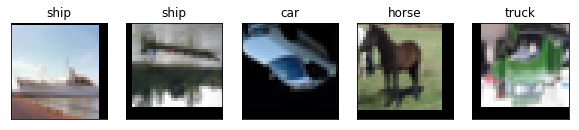

In [5]:
# Use the function above to view data
show5_v2(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
# Building the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 34, 3)
        self.fc1 = nn.Linear(34 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 34 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Create instance of Net() class for our model
net = Net()

# Conditional included for GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# To let us know which device was selected
print("Running on", device)

# To connect the running device to our model instance
net.to(device)

# Loss function and stochastic gradient descent optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Running on cpu


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.248
[1,  4000] loss: 2.022
[1,  6000] loss: 1.909
[1,  8000] loss: 1.838
[1, 10000] loss: 1.777
[2,  2000] loss: 1.717


Plot the training loss (and validation loss/accuracy, if recorded).

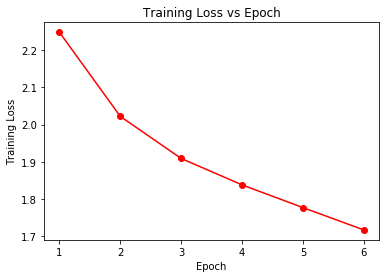

In [11]:
# Plotting the training loss

# As running on GPU isn't possible, I am saving here the running loss data for plotting purposes, without the need
# to recollect the data

running_loss = [2.248, 2.022, 1.909, 1.838, 1.777, 1.717]

plt.figure(1)
plt.title('Training Loss vs Epoch')
plt.plot(range(1,len(running_loss)+1), running_loss, 'ro-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
# NOTE: Since the GPU does not work in my workspace, I ran this block with enough iterations to achieve an accuracy
# score of 46%. I believe that if the GPU was working, I would be able to achieve a higher accuracy score.

# Testing the model
num_correct = 0
total_num = 0
# No gradients are needed here because we are testing, not training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(Variable(images.to(device))).cpu()
        _, predicted = torch.max(outputs.data, 1)
        total_num += labels.size(0)
        num_correct += (predicted == labels).sum()
    accuracy = 100 * num_correct / total_num
    print(f'Accuracy: ', accuracy)
print('Done')

Process Process-5:
Process Process-6:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6

KeyboardInterrupt: 

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Saving the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

### For this project, I build an image classifier from a neural network model using PyTorch. This model was trained and tested using the CIFAR-10 dataset. The GPU feature of the project workspace was not working properly as I wrote and tested this code, but I was able to use the CPU device to test the accuracy of my model for a subset of the data that I wanted to use. On this subset, I found a model accuracy of 46%, which is lower than the accuracy obtained by the Detectocorp's model. My accuracy is lower than the advanced solutions in the literature and it would be necessary to improve my model's accuracy to deploy it in a production-like setting. With its current state, my model would not out-perform one of the better models, so my recommendation is to buy. However, with some changes that are not too hard to implement, I believe that the accuracy of my model could be quickly improved.




## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).